# Fine-tunning utilizing SAM2

These notebook describe the process to Fine Tunning the segmentation of diseased strawberries (plants, leaves, flower, and fruits) zones. [SAM2](https://ai.meta.com/sam2/) is utilized to do so. The dataset was recollected from ecuadorian strawberries crops in combination with dataset from [Roboflow](https://universe.roboflow.com/), a firs segmentation was done using the [Polygon Annotation Tool](https://docs.roboflow.com/annotate/use-roboflow-annotate/smart-polygon) and then we downloaded the.

## 1. Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Install the neccesary dependencies

In [ ]:
# Install PyTorch
!pip install torch torchvision

# Install OpenCV
!pip install opencv-python-headless

# Install pycocotools
!pip install pycocotools

## 3. Navigate to the cloned repository and install SAM2

In [ ]:
%cd /content/drive/MyDrive/segment-anything-2
!pwd
!pip install -q -e .

/content/drive/MyDrive/segment-anything-2
/content/drive/MyDrive/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 14.2 kB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


## 4. Download dataset from Robloflow and save it in the local directory

In [ ]:
import os
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to save the dataset in Google Drive
save_dir = '/content/drive/MyDrive/strawberrySAM2/dataset'
os.makedirs(save_dir, exist_ok=True)

# Download the dataset from Roboflow
# Replace the URL with the actual download link from Roboflow
dataset_url = 'https://universe.roboflow.com/ds/eyVZJuBshS?key=2voMKzvr9g'
!wget -O {save_dir}/dataset.zip {dataset_url}

# Unzip the dataset
!unzip {save_dir}/dataset.zip -d {save_dir}

## 5. Download Chekpoints.
For the fine-tuning process, we need to start with pre-trained SAM2 model weights. These weights, called "checkpoints," are the starting point for further training. The checkpoints have been trained on a wide range of images, and by fine-tuning them on our specific dataset, we can achieve better performance on our target tasks.

In [ ]:
# Download the checkpoints to Google Drive
!wget -O /content/drive/MyDrive/segment-anything-2/checkpoints-before-fine-tunning/sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
!wget -O /content/drive/MyDrive/segment-anything-2/checkpoints-before-fine-tunning/sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
!wget -O /content/drive/MyDrive/segment-anything-2/checkpoints-before-fine-tunning/sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"
!wget -O /content/drive/MyDrive/segment-anything-2/checkpoints-before-fine-tunning/sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

## 5. Prepare and visualize the data

loading annotations into memory...
Done (t=38.81s)
creating index...
index created!
loading annotations into memory...
Done (t=4.94s)
creating index...
index created!
loading annotations into memory...
Done (t=4.19s)
creating index...
index created!


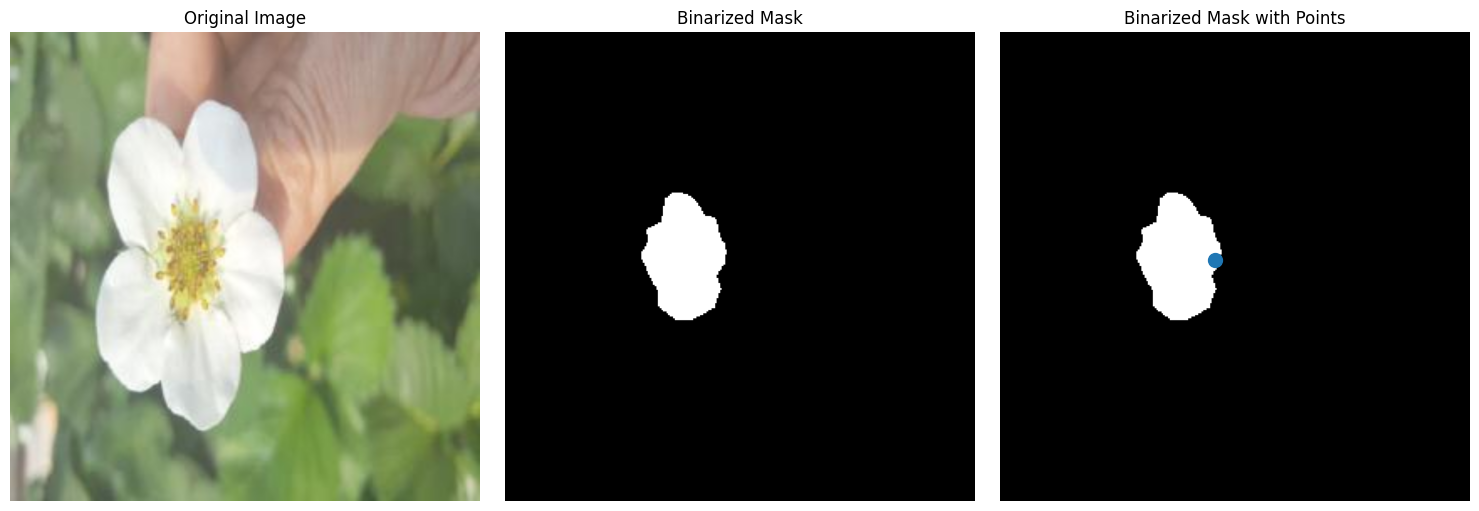

In [ ]:
import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pycocotools.coco import COCO

# Define paths to the dataset splits
data_dir = '/content/drive/MyDrive/strawberrySAM2/dataset'
splits = ['train', 'test', 'valid']

# Function to prepare data for a given split
def prepare_data(split):
    split_dir = os.path.join(data_dir, split)
    images_dir = split_dir  # Images are in the same directory
    annotations_path = os.path.join(split_dir, '_annotations.coco.json')

    # Load COCO annotations
    coco = COCO(annotations_path)

    # Get image IDs
    image_ids = coco.getImgIds()

    # Prepare the data list
    data = []
    for image_id in image_ids:
        image_info = coco.loadImgs(image_id)[0]
        image_path = os.path.join(images_dir, image_info['file_name'])

        # Get annotations for the image
        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)

        # Create a binary mask for each annotation
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, coco.annToMask(ann) * ann['category_id'])

        # Save the mask as a PNG file
        mask_dir = os.path.join(split_dir, 'masks')
        os.makedirs(mask_dir, exist_ok=True)
        mask_path = os.path.join(mask_dir, f"{image_info['file_name'].split('.')[0]}_mask.png")
        cv2.imwrite(mask_path, mask)

        # Append image and mask paths to the data list
        data.append({'image': image_path, 'annotation': mask_path})

    return data

# Prepare data for each split
train_data = prepare_data('train')
test_data = prepare_data('test')
valid_data = prepare_data('valid')

# Function to read and resize images and masks
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor 1024is the size for SAM2
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])

    points = np.array(points)

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

## 6. Building the SAM2 Model

Here we specify the paths to the pretrained checkpoints. We can specify which architecture wan to utilize: tiny, small, base plus, or large.

**Note:** The pretrained checkpoint version must match the model configuration e.g **sam2_checkpoint= sam2_hiera_small.pt** and **model_cfg= sam2_hiera_small**. It can no be like this **sam2_checkpoint= sam2_hiera_small.pt** and **model_cfg= sam2_hiera_tiny**

In [ ]:
# Setting Checkpoint and Configuration:
sam2_checkpoint = 'sam2_hiera_small.pt' # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = 'sam2_hiera_s.yaml'  # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

'''
sam2_checkpoint and model_cfg are variables storing
the paths to the model's checkpoint file and
configuration file, respectively. These files are
used to load the pre-trained model and its settings.
'''

# Building and Initializing the Model:
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
'''
initializes the model using the specified configuration and
checkpoint, and sets it to run on a CUDA-enabled GPU.
'''
predictor = SAM2ImagePredictor(sam2_model)
'''
creates a predictor object that will use the
initialized model to make predictions on images.
'''

'\ncreates a predictor object that will use the\ninitialized model to make predictions on images.\n'

**2. Configure hyperparameters**

In [ ]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

'''
These lines set the sam_mask_decoder and
sam_prompt_encoder components of the model
to training mode. This is important because
certain layers like dropout and batch normalization
behave differently during training and evaluation.
'''

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5
'''
This initializes the AdamW optimizer with the
model's parameters, a learning rate of 0.0001,
and a weight decay of 1e-4. The optimizer is
responsible for updating the model's weights during training.
'''
# Mix precision.
scaler = torch.cuda.amp.GradScaler()
'''
This creates a gradient scaler for mixed
precision training, which can speed up training
and reduce memory usage by using both 16-bit
and 32-bit floating-point types.
'''

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param
'''
This sets the number of steps (iterations)
for which the model will be trained.
'''

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"
'''
This specifies the name for the fine-tuned
model, which can be used later for saving
or referencing the model.
'''

## 7. Tranining function

In [ ]:
# Configure optimizer.
optimizer = torch.optim.AdamW(params=predictor.model.parameters(), lr=1e-4, weight_decay=1e-4)  # 1e-5, weight_decay = 4e-5

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.8)  # 500, 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating
# Define the path to save the model weights in Google Drive
save_dir = '/content/drive/MyDrive/strawberrySAM2/fine-tunned-models-sam2'
os.makedirs(save_dir, exist_ok=True)

def train(predictor, train_data, step, mean_iou):

    with torch.amp.autocast(device_type='cuda'):
        image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)

        if image is None or mask is None or num_masks == 0:
            return

        input_label = np.ones((num_masks, 1))

        if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
            return

        if input_point.size == 0 or input_label.size == 0:
            return

        predictor.set_image(image)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
            input_point, input_label, box=None, mask_logits=None, normalize_coords=True
        )

        if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
            return

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels), boxes=None, masks=None
        )

        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )

        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
        prd_mask = torch.sigmoid(prd_masks[:, 0])

        seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6) - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)).mean()

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)

        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.05

        # Apply gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

        if step % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            predictor.model.zero_grad(set_to_none=True)

        # scheduler.step()
        # Save the model weights periodically
        if step % 500 == 0:
            FINE_TUNED_MODEL = os.path.join(save_dir, f"fine_tuned_sam2_strawberry{step}.torch")
            torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)
            print(f"Model weights saved to {FINE_TUNED_MODEL}")

        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

        if step % 100 == 0:  # Log every 100 steps
            current_lr = optimizer.param_groups[0]["lr"]
            print(f"Step {step}: Current LR = {current_lr:.6f}, IoU = {mean_iou:.6f}, Seg Loss = {seg_loss:.6f}")
    return mean_iou

## 7.1 Validate function

In [ ]:

def validate(predictor, test_data, step, mean_iou):
    predictor.model.eval()
    with torch.amp.autocast(device_type='cuda'):
        with torch.no_grad():
            image, mask, input_point, num_masks = read_batch(test_data, visualize_data=False)

            if image is None or mask is None or num_masks == 0:
                return

            input_label = np.ones((num_masks, 1))

            if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
                return

            if input_point.size == 0 or input_label.size == 0:
                return

            predictor.set_image(image)
            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                input_point, input_label, box=None, mask_logits=None, normalize_coords=True
            )

            if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
                return

            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=(unnorm_coords, labels), boxes=None, masks=None
            )

            batched_mode = unnorm_coords.shape[0] > 1
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=batched_mode,
                high_res_features=high_res_features,
            )

            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])

            seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6) - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)).mean()

            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)

            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss = seg_loss + score_loss * 0.05

            # Apply gradient accumulation
            loss = loss / accumulation_steps

            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

            if mean_iou > best_iou:
                # Update the best IoU
                best_iou = mean_iou
                # Save the model checkpoint
                torch.save(predictor.model.state_dict(), f"best_model_{step}.pt")
                print(f"Step {step}: New best IoU achieved: {best_iou:.6f}. Model saved.")

            if step % 100 == 0:  # Log every 100 steps
                current_lr = optimizer.param_groups[0]["lr"]
                print(f"Step {step}: Current LR = {current_lr:.6f}, Valid_IoU = {mean_iou:.6f}, Valid_Seg Loss = {seg_loss:.6f}")
    return mean_iou

## 7.2 Calling functions

In [ ]:
train_mean_iou = 0
valid_mean_iou = 0

best_iou = 0

for step in range(1, NO_OF_STEPS + 1):
    train_mean_iou = train(predictor, train_data, step, train_mean_iou)
    valid_mean_iou = validate(predictor, test_data, step, valid_mean_iou)

## 7. Start Trainning (Alternative 1)

In [ ]:
import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pycocotools.coco import COCO

# Define paths to the dataset splits
data_dir = '/content/drive/MyDrive/strawberrySAM2/dataset'
splits = ['train', 'test', 'valid']

# Function to prepare data for a given split
def prepare_data(split):
    split_dir = os.path.join(data_dir, split)
    images_dir = split_dir  # Images are in the same directory
    annotations_path = os.path.join(split_dir, '_annotations.coco.json')

    # Load COCO annotations
    coco = COCO(annotations_path)

    # Get image IDs
    image_ids = coco.getImgIds()

    # Prepare the data list
    data = []
    for image_id in image_ids:
        image_info = coco.loadImgs(image_id)[0]
        image_path = os.path.join(images_dir, image_info['file_name'])

        # Get annotations for the image
        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)

        # Create a binary mask for each annotation
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, coco.annToMask(ann) * ann['category_id'])

        # Save the mask as a PNG file
        mask_dir = os.path.join(split_dir, 'masks')
        os.makedirs(mask_dir, exist_ok=True)
        mask_path = os.path.join(mask_dir, f"{image_info['file_name'].split('.')[0]}_mask.png")
        cv2.imwrite(mask_path, mask)

        # Append image and mask paths to the data list
        data.append({'image': image_path, 'annotation': mask_path})

    return data

# Prepare data for each split
train_data = prepare_data('train')
test_data = prepare_data('test')
valid_data = prepare_data('valid')

# Function to read and resize images and masks
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])

    points = np.array(points)

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

# Fine-tuning SAM2

# Define the path to save the model weights in Google Drive
save_dir = '/content/drive/MyDrive/strawberrySAM2/fine-tunned-models-sam2'
os.makedirs(save_dir, exist_ok=True)

# Initialize the SAM2 model
sam2_checkpoint = "sam2_hiera_small.pt"
model_cfg = "sam2_hiera_s.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Initialize the predictor
predictor = SAM2ImagePredictor(sam2_model)

# Set the model to training mode
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)

# Configure the optimizer
optimizer = torch.optim.AdamW(params=predictor.model.parameters(), lr=0.0001, weight_decay=1e-4)

# Initialize gradient scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2)
accumulation_steps = 4 # Initialize scheduler and Gradient Accumulation Initialization
 # Number of steps to accumulate gradients before updating

# Initialize mean_iou
mean_iou = 0

# Set the number of training steps
NO_OF_STEPS = 3000

# Training loop
for step in range(1, NO_OF_STEPS + 1):  # Iterates through the training steps
    with torch.cuda.amp.autocast():
        # Data Loading and Preprocessing
        image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)

        if image is None or mask is None or num_masks == 0:
            continue

        input_label = np.ones((num_masks, 1))
        if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
            continue

        if input_point.size == 0 or input_label.size == 0:
            continue

        # Model prediction
        predictor.set_image(image)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
        if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
            continue

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels), boxes=None, masks=None,
        )

        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

        # Loss Calculation
        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
        prd_mask = torch.sigmoid(prd_masks[:, 0])
        seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.05

        # Apply gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

        if step % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            predictor.model.zero_grad()

        # Update scheduler
        scheduler.step()

        # Save the model weights periodically
        if step % 500 == 0:
            FINE_TUNED_MODEL = os.path.join(save_dir, f"fine_tuned_sam2_{step}.torch")
            torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)
            print(f"Model weights saved to {FINE_TUNED_MODEL}")

        # Log the training progress
        if step == 1:
            mean_iou = 0

        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

        if step % 100 == 0:
            print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)

prepare the data for inference

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


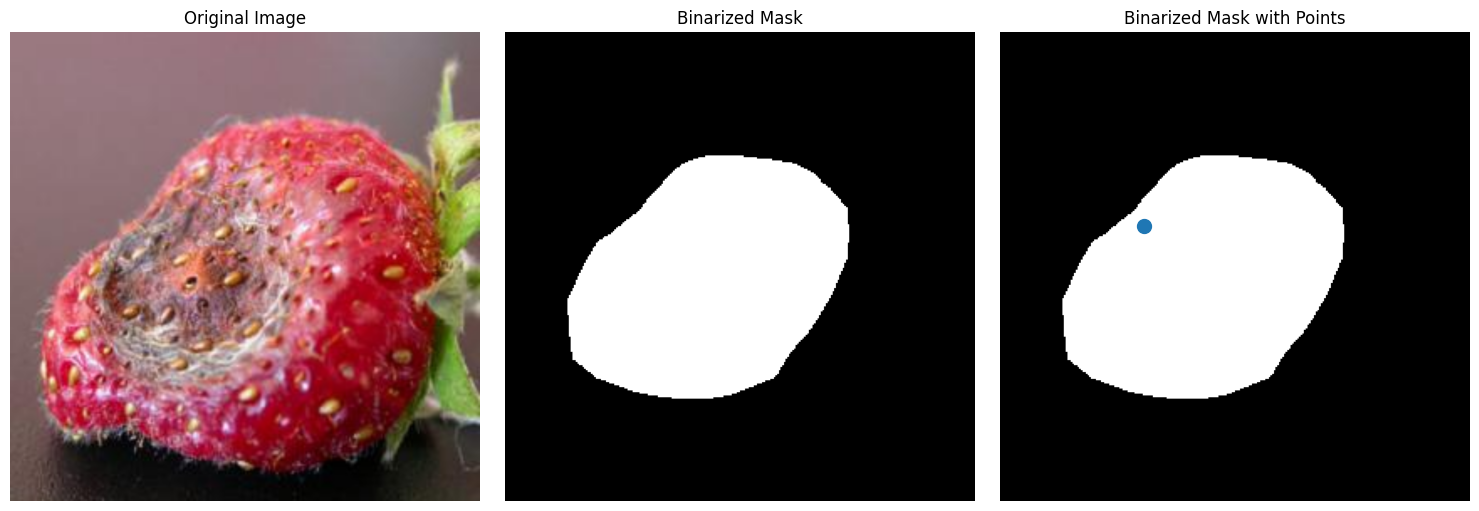

In [ ]:
import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pycocotools.coco import COCO

# Define paths to the dataset splits
data_dir = '/content/drive/MyDrive/strawberrySAM2/dataset'
splits = ['train', 'test', 'valid']

# Function to prepare data for a given split
def prepare_data(split):
    split_dir = os.path.join(data_dir, split)
    images_dir = split_dir  # Images are in the same directory
    annotations_path = os.path.join(split_dir, '_annotations.coco.json')

    # Load COCO annotations
    coco = COCO(annotations_path)

    # Get image IDs
    image_ids = coco.getImgIds()

    # Prepare the data list
    data = []
    for image_id in image_ids:
        image_info = coco.loadImgs(image_id)[0]
        image_path = os.path.join(images_dir, image_info['file_name'])

        # Get annotations for the image
        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)

        # Create a binary mask for each annotation
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, coco.annToMask(ann) * ann['category_id'])

        # Save the mask as a PNG file
        mask_dir = os.path.join(split_dir, 'masks')
        os.makedirs(mask_dir, exist_ok=True)
        mask_path = os.path.join(mask_dir, f"{image_info['file_name'].split('.')[0]}_mask.png")
        cv2.imwrite(mask_path, mask)

        # Append image and mask paths to the data list
        data.append({'image': image_path, 'annotation': mask_path})

    return data

# Prepare data for each split
#train_data = prepare_data('train')
test_data = prepare_data('test')
#valid_data = prepare_data('valid')

# Function to read and resize images and masks
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])

    points = np.array(points)

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

# 8.1 Inference

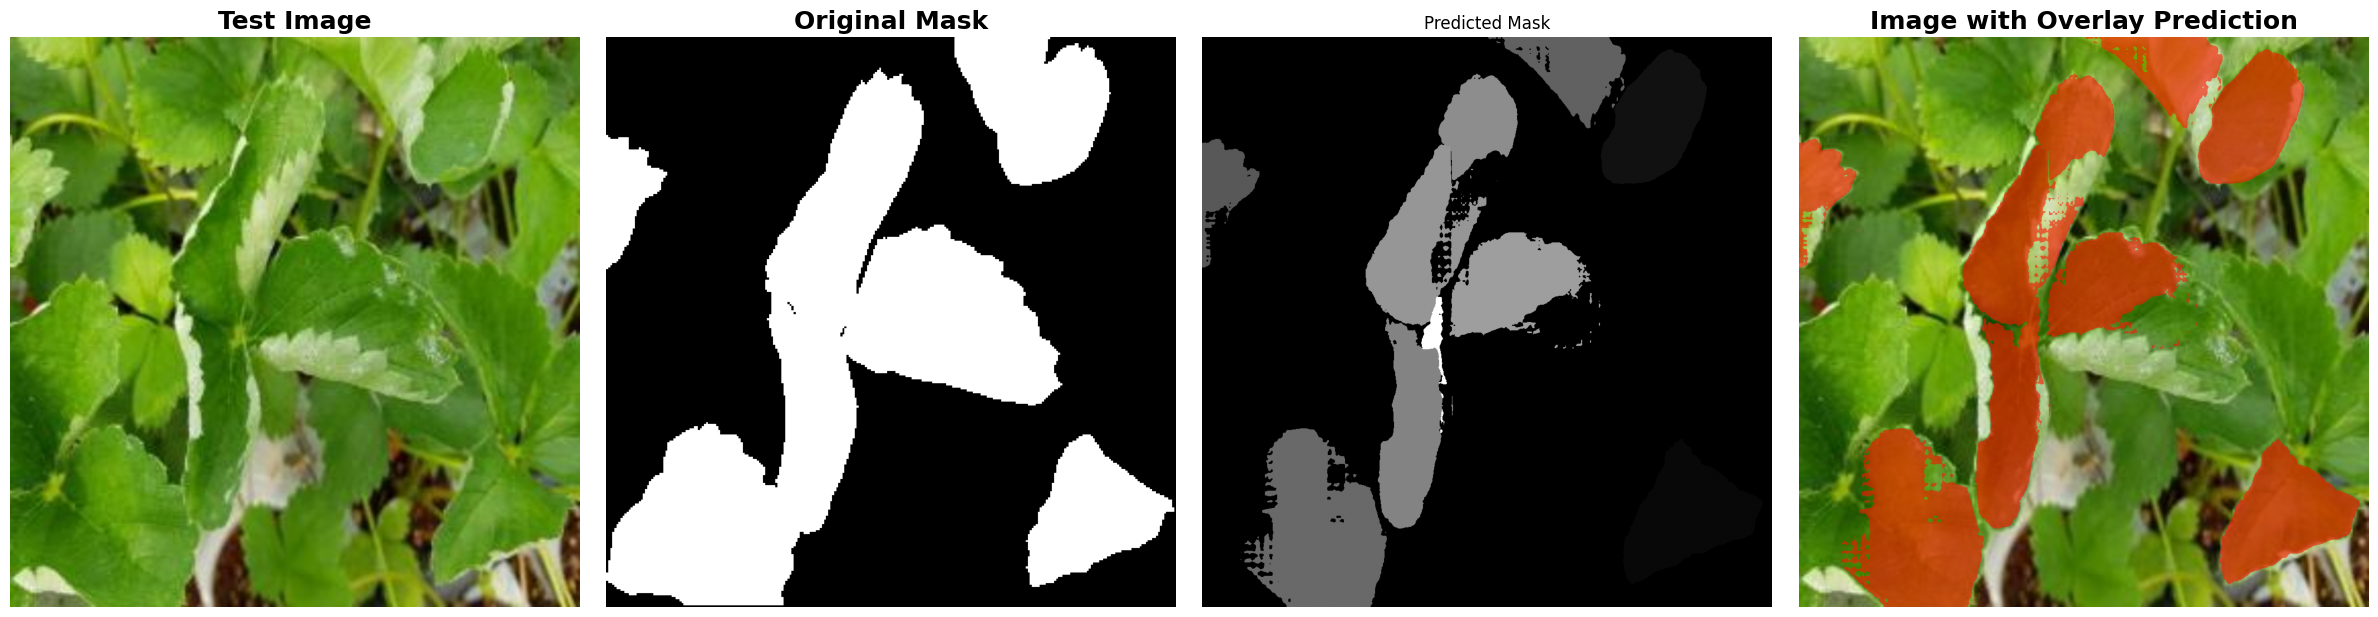

Final layout saved at: /content/drive/MyDrive/strawberrySAM2/fine-tunned-models-sam2/finetuning-sam2-pretrained-sam2-pred_7.png


In [ ]:
import random
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

   ####################################
   # Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
# print(selected_entry)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']
# print(mask_path,'mask path')

# Load the selected image and mask
image, target_mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(target_mask, num_samples)

sam2_checkpoint = "/content/drive/MyDrive/segment-anything-2/checkpoints-before-fine-tunning/sam2_hiera_small.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_s.yaml"  # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask


# Define the RGB color and transparency (alpha)
color = (255, 20, 0)  # Green (Modify as needed)
alpha = 0.6  # Transparency factor (0: fully transparent, 1: fully opaque)

# Create an RGB mask with the chosen color
colored_seg_map = np.zeros_like(image, dtype=np.uint8)
colored_seg_map[..., 0] = color[0]  # Red channel
colored_seg_map[..., 1] = color[1]  # Green channel
colored_seg_map[..., 2] = color[2]  # Blue channel

# Create a binary mask where segmentation is present
mask_indices = seg_map > 0

# Blend the original image and the colored mask using transparency
image_with_mask_pt_1 = image.copy()
image_with_mask_pt_1[mask_indices] = (
    (1 - alpha) * image[mask_indices] + alpha * colored_seg_map[mask_indices]
).astype(np.uint8)

# Function to generate a unique output file name with a counter
def get_unique_output_path(base_path, file_name, extension=".png"):
    counter = 1
    output_path = os.path.join(base_path, f"{file_name}_{counter}{extension}")
    # Check for existing files and increment counter
    while os.path.exists(output_path):
        counter += 1
        output_path = os.path.join(base_path, f"{file_name}_{counter}{extension}")
    return output_path

# Define the base path and file name
base_path = "/content/drive/MyDrive/strawberrySAM2/fine-tunned-models-sam2"  # Current directory or specify the desired folder
file_name = "finetuning-sam2-pretrained-sam2-pred"

# Generate a unique output path
output_path = get_unique_output_path(base_path, file_name)

# Visualization: Create the figure and add subplots
plt.figure(figsize=(24, 6))

plt.subplot(1, 4, 1)
plt.title('Test Image', fontsize=18, fontweight='bold')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Original Mask', fontsize=18, fontweight='bold')
plt.imshow(target_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Predicted Mask')
plt.imshow(seg_map, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Image with Overlay Prediction', fontsize=18, fontweight='bold')
plt.imshow(image_with_mask_pt_1)
plt.axis('off')


# Adjust layout and save the final figure as an image
plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save with high resolution (300 DPI)
plt.show()

print(f"Final layout saved at: {output_path}")

<ipython-input-18-424dd7d80066>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))


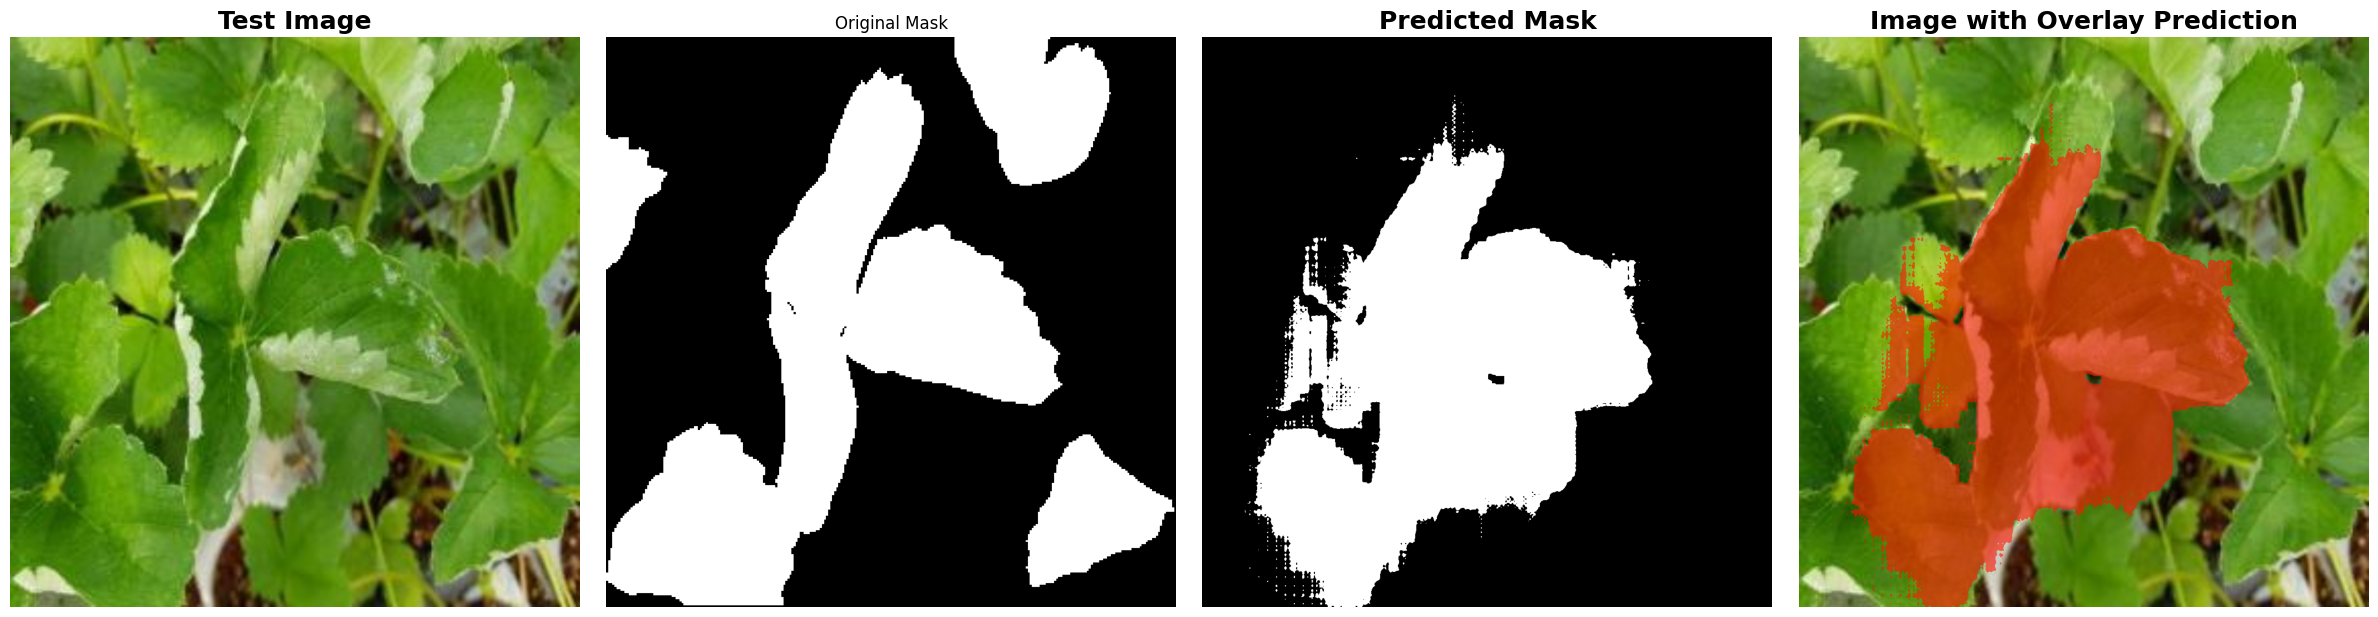

Final layout saved at: ./finetuning-sam2-pretrained-sam2-ft_7.png


In [ ]:
# using the same selected entry to compare the the result with the same image
image_path = selected_entry['image']
mask_path = selected_entry['annotation']
# print(mask_path,'mask path')

# Load the selected image and mask
image, target_mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(target_mask, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "/content/drive/MyDrive/strawberrySAM2/fine-tunned-models-sam2/fine_tuned_sam2_3000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Define the RGB color and transparency (alpha)
color = (255, 20, 0)  # Green (Modify as needed)
alpha = 0.6  # Transparency factor (0: fully transparent, 1: fully opaque)

# Create an RGB mask with the chosen color
colored_seg_map = np.zeros_like(image, dtype=np.uint8)
colored_seg_map[..., 0] = color[0]  # Red channel
colored_seg_map[..., 1] = color[1]  # Green channel
colored_seg_map[..., 2] = color[2]  # Blue channel

# Create a binary mask where segmentation is present
mask_indices = seg_map > 0

# Blend the original image and the colored mask using transparency
image_with_mask_ft = image.copy()
image_with_mask_ft[mask_indices] = (
    (1 - alpha) * image[mask_indices] + alpha * colored_seg_map[mask_indices]
).astype(np.uint8)

# Function to generate a unique output file name with a counter
def get_unique_output_path(base_path, file_name, extension=".png"):
    counter = 1
    output_path = os.path.join(base_path, f"{file_name}_{counter}{extension}")
    # Check for existing files and increment counter
    while os.path.exists(output_path):
        counter += 1
        output_path = os.path.join(base_path, f"{file_name}_{counter}{extension}")
    return output_path

# Define the base path and file name
base_path = "."  # Current directory or specify the desired folder
file_name = "finetuning-sam2-pretrained-sam2-ft"

# Generate a unique output path
output_path = get_unique_output_path(base_path, file_name)

# Visualization: Create the figure and add subplots
plt.figure(figsize=(24, 6))

plt.subplot(1, 4, 1)
plt.title('Test Image', fontsize=18, fontweight='bold')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Original Mask')
plt.imshow(target_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Predicted Mask', fontsize=18, fontweight='bold')
plt.imshow(seg_map, cmap='grey')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Image with Overlay Prediction', fontsize=18, fontweight='bold')
plt.imshow(image_with_mask_ft)
plt.axis('off')

# Adjust layout and save the final figure as an image
plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save with high resolution (300 DPI)
plt.show()

print(f"Final layout saved at: {output_path}")

## 8. Inference

<ipython-input-67-f570fce2e31d>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))


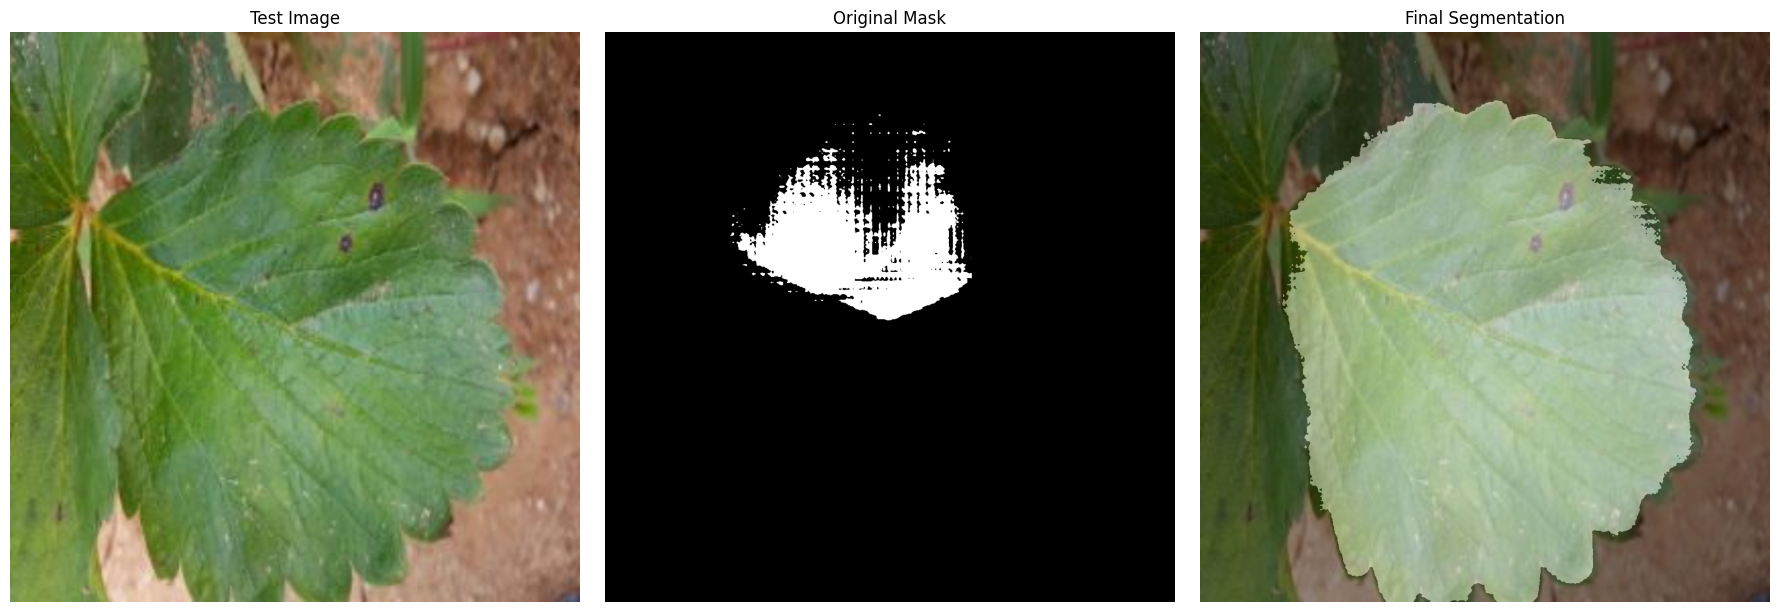

In [ ]:
import random

# Inference with the fine-tuned model

# Reads and resizes an image and its corresponding mask.
def read_image(image_path, mask_path):  # read and resize image and mask
    img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
    mask = cv2.imread(mask_path, 0)  # Read the mask from mask_path in grayscale
    r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])  # Calculates the resize ratio to ensure the largest dimension is 1024 pixels
    img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))  # Resizes the image using the calculated ratio
    mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)  # Resizes the mask using the same ratio with nearest neighbor interpolation
    return img, mask

# Samples a specified number of points from within the mask where the mask value is greater than 0.
def get_points(mask, num_points):  # Sample points inside the input mask
    points = []
    # Finds the coordinates of all non-zero pixels in the mask.
    coords = np.argwhere(mask > 0)
    # Loops to sample num_points points.
    for i in range(num_points):
        # Randomly selects a coordinate from the non-zero pixels.
        yx = np.array(coords[np.random.randint(len(coords))])
        # Appends the selected point to the list, switching the order to [x, y].
        points.append([[yx[1], yx[0]]])
    # Returns the list of sampled points as a NumPy array.
    return np.array(points)

# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load the selected image and mask
image, mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

# Load the fine-tuned model and its weights
FINE_TUNED_MODEL_WEIGHTS = "/content/drive/MyDrive/strawberrySAM2/fine-tunned-models-sam2/fine_tuned_sam2_500.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks using the input points.
with torch.no_grad():
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=np.ones([input_points.shape[0], 1])
    )

# Process the predicted masks and sort by scores
# Converts masks and scores to numpy arrays and
# sorts masks by scores in descending order
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
    mask = sorted_masks[i]
    if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
        continue

    mask_bool = mask.astype(bool)
    mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
    seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
    occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(image)
plt.imshow(seg_map,cmap='gray', alpha=0.4)
plt.axis('off')

plt.tight_layout()
plt.show()
##################3



This notebook was created by [Inti T.](https://www.linkedin.com/in/inti14/) as part of his Master thesis project in Mechatronics Engineering at the [University of Debrecen](https://edu.unideb.hu/p/faculty-of-engineering), Hungary.
